In [2]:
import os
%load_ext autoreload
%autoreload 2

In [3]:
## OpenJPG download
import imageio
imageio.plugins.freeimage.download()

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import tensor, Tensor, nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.functional import F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision as tv
import torcheval as te
from random import choice
from pathlib import Path
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from helper.imghelper import show_images_for_patient, rescale_img_to_hu

from sklearn.preprocessing import MinMaxScaler

import warnings

mpl.rcParams['image.cmap'] = 'gray'


In [72]:
datapath = Path('data/rsna')
imgpath = datapath/'train_images'
submissionpath = datapath/'test_images'
IMG_SIZE = 512

In [6]:
info_df = pd.read_csv(datapath/'train.csv')

In [18]:
info_df.head(1)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False


In [8]:
# from helper.imghelper import show_images_for_patient, rescale_img_to_hu
# rand_pat = info_df['patient_id'].sample(n=1).values[0]
# print(info_df[info_df['patient_id'] == rand_pat])
# show_images_for_patient(rand_pat, is_local=True)

In [50]:
from sklearn.preprocessing import MinMaxScaler
import cv2

In [89]:
class CancerDS(Dataset):
    def __init__(self, annot_df: pd.DataFrame, slc: slice, scaler: callable, imgpath: Path, transforms=None):
        super(CancerDS, self).__init__()

        self.annotations = annot_df.iloc[slc]
        self.annotations['path'] = imgpath / (self.annotations['patient_id'].astype(str)) / (self.annotations['image_id'].astype(str) + '.dcm' )

        self.scaler = MinMaxScaler((0, 1))
        scaler_range = np.arange(0, 4915, 1).reshape(-1, 1)
        self.scaler.fit(scaler_range)

        self.transforms = transforms

    def __len__(self) -> int:
        return self.annotations['image_id'].count()

    def __getitem__(self, item) -> (Tensor, Tensor):
        image_data = rescale_img_to_hu(pydicom.dcmread(self.annotations.loc[item, 'path']), scaler=self.scaler)
        return self.transforms(image_data).reshape(-1, IMG_SIZE), self.annotations.loc[item, 'cancer']

    def get_df(self) -> pd.DataFrame:
        return self.annotations

Cancer: 0


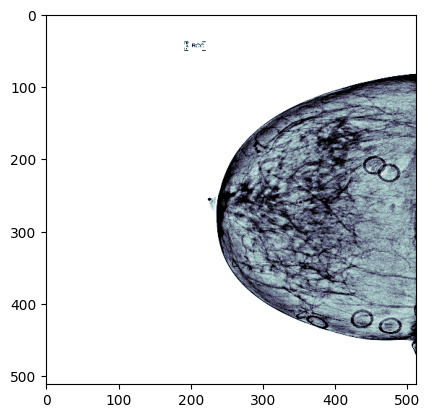

In [235]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ColorJitter(brightness=(0.5, 1.5), contrast=(0.95, 2))
])

with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    test = CancerDS(info_df, slice(0, 1000), None, imgpath, transforms)
    tdf = test.get_df()

import os
rnd = choice(range(0, len(test)))
print(f'Cancer: {test[rnd][1]}')
plt.imshow(test[rnd][0] * -1, cmap="bone")

In [12]:
info_df.head(1)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
